# Bayesian inference

## Time to capture prey

### Load packages

In [1]:
using Distributions
using DataFrames
using CairoMakie
using Turing
import CSV

### Read data

Simulated data corresponding to the time fur seals need to capture their first prey.

In [2]:
data = CSV.read("../data/simulated/time-to-capture.csv", DataFrame)
n = nrow(data)

10

### Bayesian inference with conjugate posterior

In [3]:
a, b = 2, 30 ## hyperparametros
prior = InverseGamma(a, b)
posterior = InverseGamma(n + a, b + sum(data.time))

InverseGamma{Float64}(
invd: Gamma{Float64}(α=12.0, θ=0.0031679246571944463)
θ: 315.6640729219907
)


Let's visualise the prior and posterior distribution:

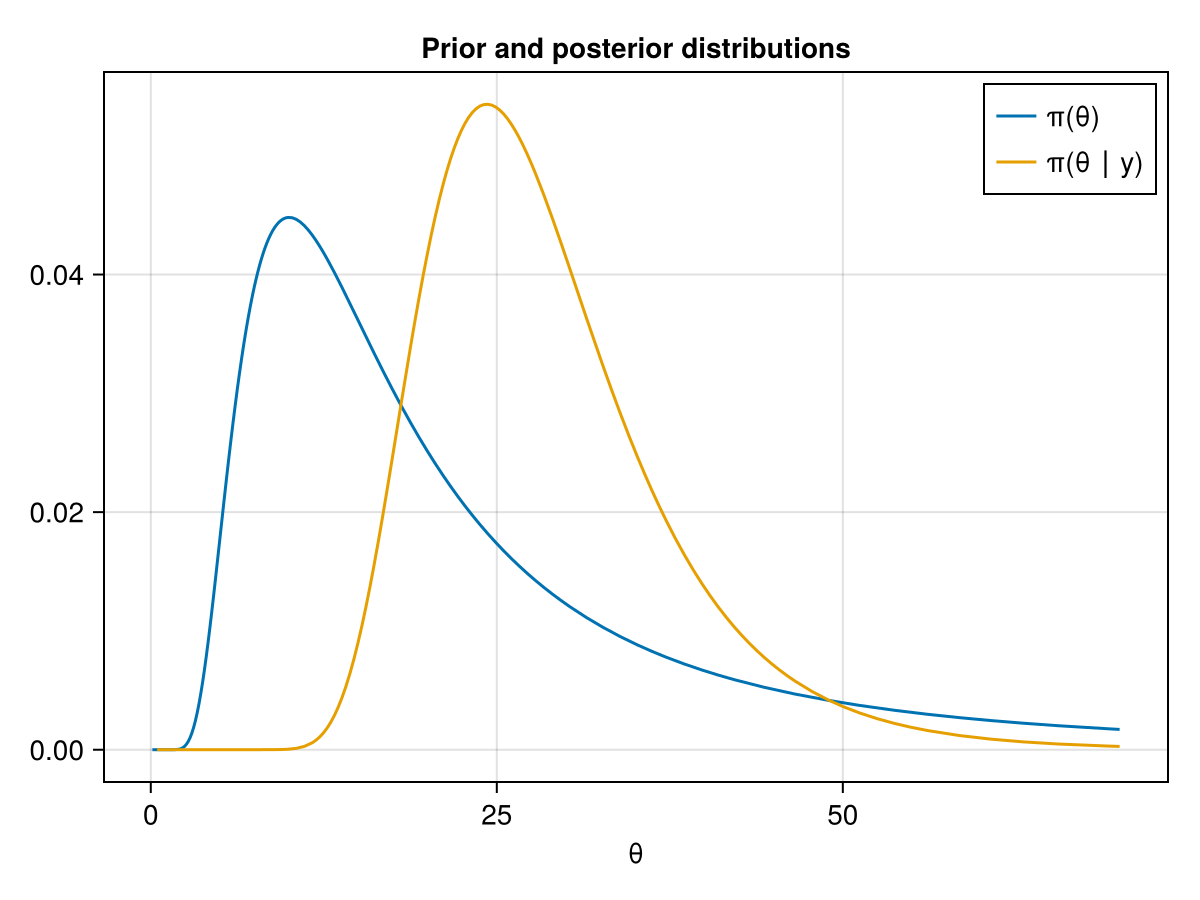

In [4]:
axis_args = (xlabel = "θ", title = "Prior and posterior distributions")
lines(0..70, x -> pdf(prior, x), label = "π(θ)", axis = axis_args)
lines!(0..70, x -> pdf(posterior, x), label = "π(θ ∣ y)")
axislegend()
current_figure()

#### Point estimate

In [5]:
mean(posterior)

28.696733901999153

In [6]:
var(posterior)

82.35025366421475

#### Credible interval

In [7]:
α = 0.05
ci_q = quantile(posterior, [α/2, 1 - α/2])

2-element Vector{Float64}:
 16.038179821091777
 50.90883787182139

In [8]:
ch = Chains(rand(posterior, 20000), [:θ])
ci_hpd = DataFrame(hpd(ch))
ci_hpd = vcat(ci_hpd.lower, ci_hpd.upper)

2-element Vector{Float64}:
 14.471656857947016
 46.8812624611551

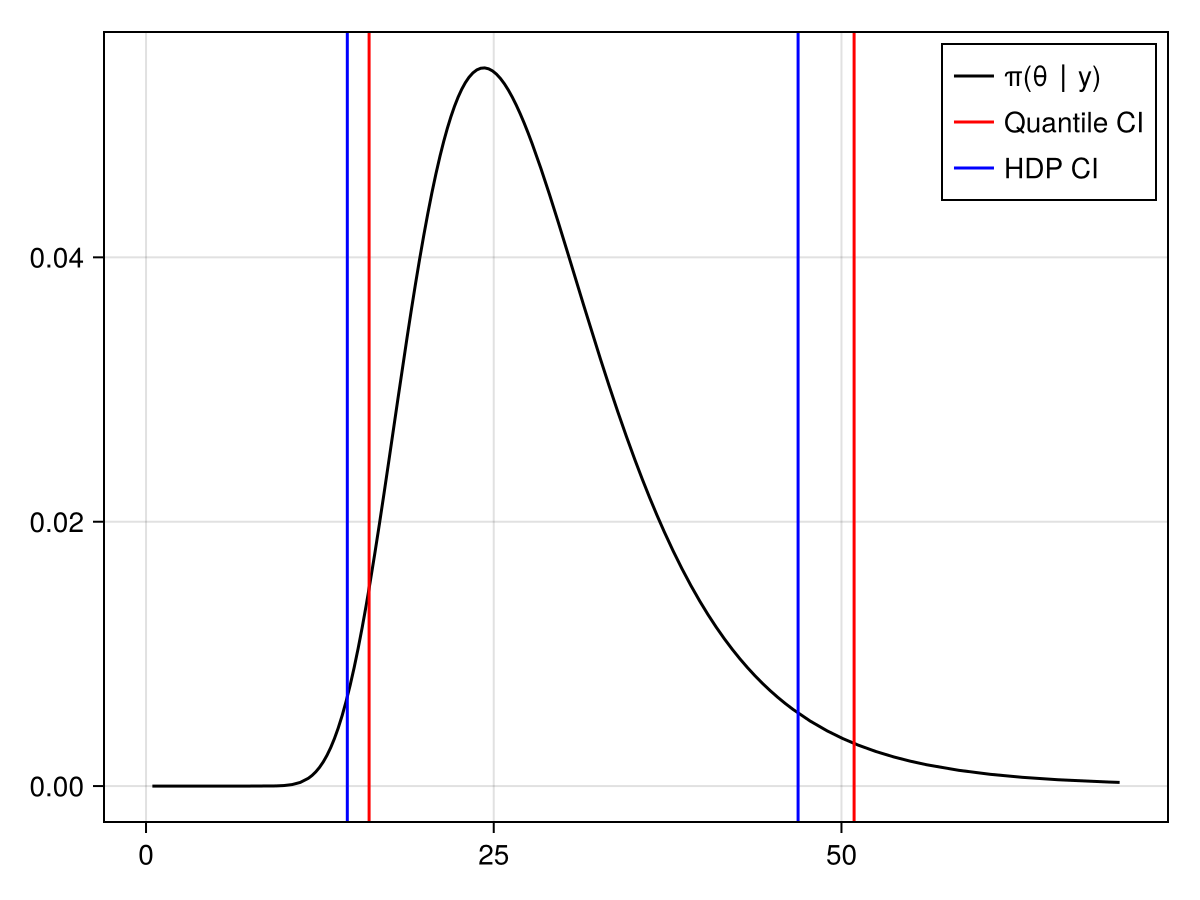

In [9]:
lines(0..70, x -> pdf(posterior, x), label = "π(θ ∣ y)", color = :black)
vlines!(ci_q, label = "Quantile CI", color = :red)
vlines!(ci_hpd, label = "HDP CI", color = :blue)
axislegend()
current_figure()

#### Comparison with a classical MLE estimator

In [10]:
est = Normal(mean(data.time), sqrt(var(data.time) / 10))

Normal{Float64}(μ=28.566407292199067, σ=11.207257206548583)

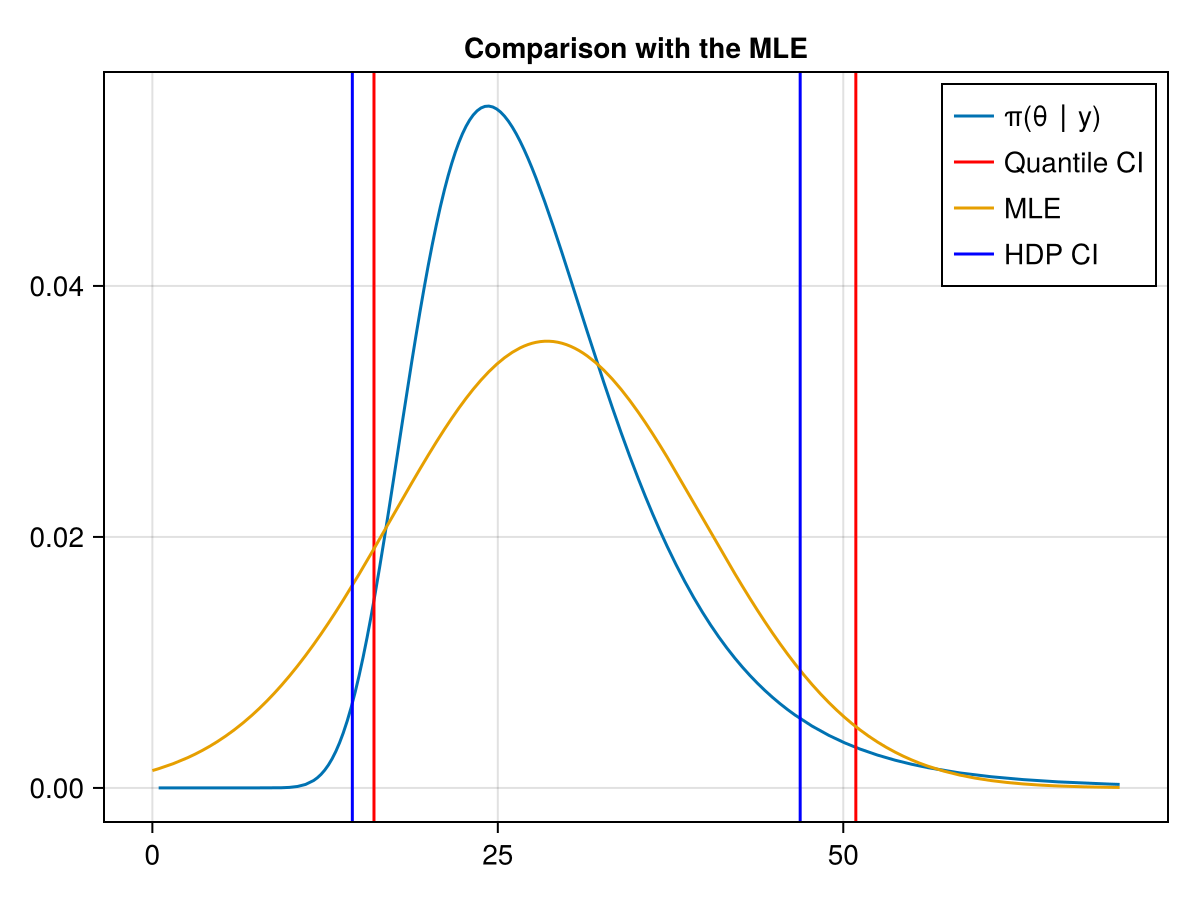

In [11]:
lines(0..70, x -> pdf(posterior, x), label = "π(θ ∣ y)",
    axis = (;title = "Comparison with the MLE")
)
vlines!(ci_q, label = "Quantile CI", color = :red)
lines!(0..70, x -> pdf(est, x), label = "MLE")
vlines!(ci_hpd, label = "HDP CI", color = :blue)
axislegend()
current_figure()

#### Excedance probability

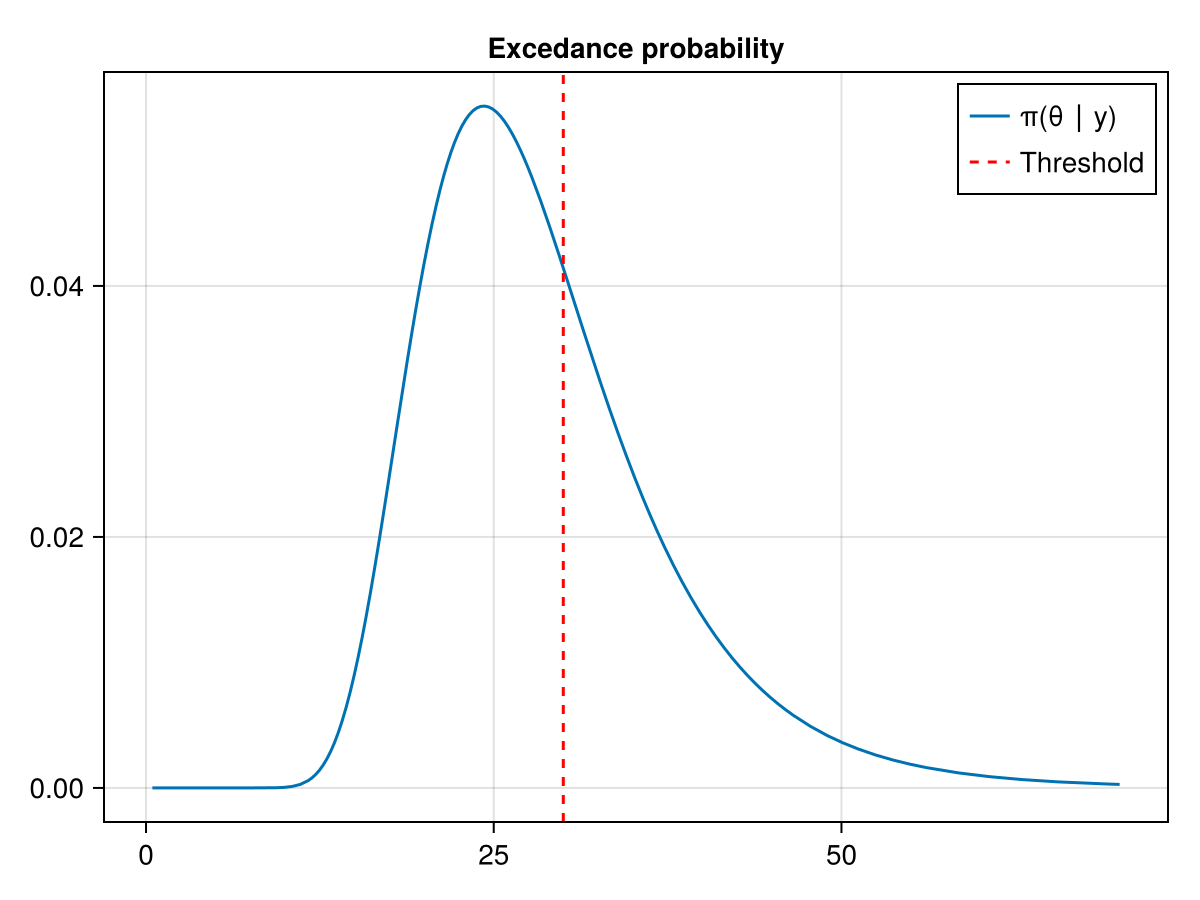

In [12]:
lines(0..70, x -> pdf(posterior, x), label = "π(θ ∣ y)",
    axis = (; title = "Excedance probability"))
vlines!([30], linestyle = :dash, label = "Threshold", color = :red)
axislegend()
current_figure()

In [13]:
1 - cdf(posterior, 30)

0.363887865883776

#### A function of the parameter

Distribution of a more complex function $log(\theta)$.

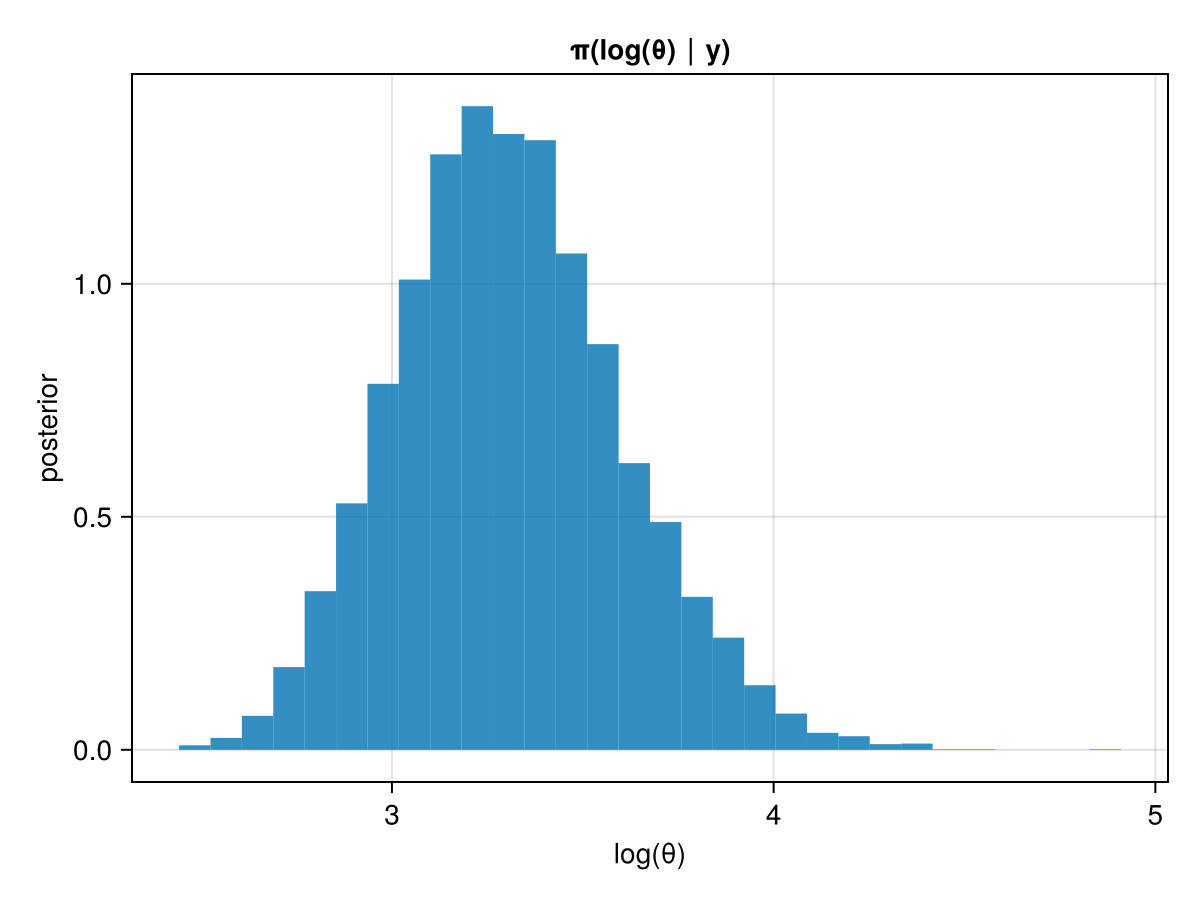

In [14]:
hist(log.(rand(posterior, 10000)), normalization = :pdf, bins = 30,
    axis = (xlabel = "log(θ)", ylabel = "posterior", title = "π(log(θ) ∣ y)")
)

mean of a more complex function

In [15]:
mean(log.(rand(posterior, 10000))) # adequate

3.3117867974734674

In [16]:
log(mean(posterior)) # wrong

3.356783314965642

In [17]:
quantile(log.(rand(posterior, 10000)), [α/2, 1 - α/2]) # adequate

2-element Vector{Float64}:
 2.77247716237455
 3.9185506101787295

#### Predictive distribution

In [18]:
an = n + a
bn = b + sum(data.time)

315.6640729219907

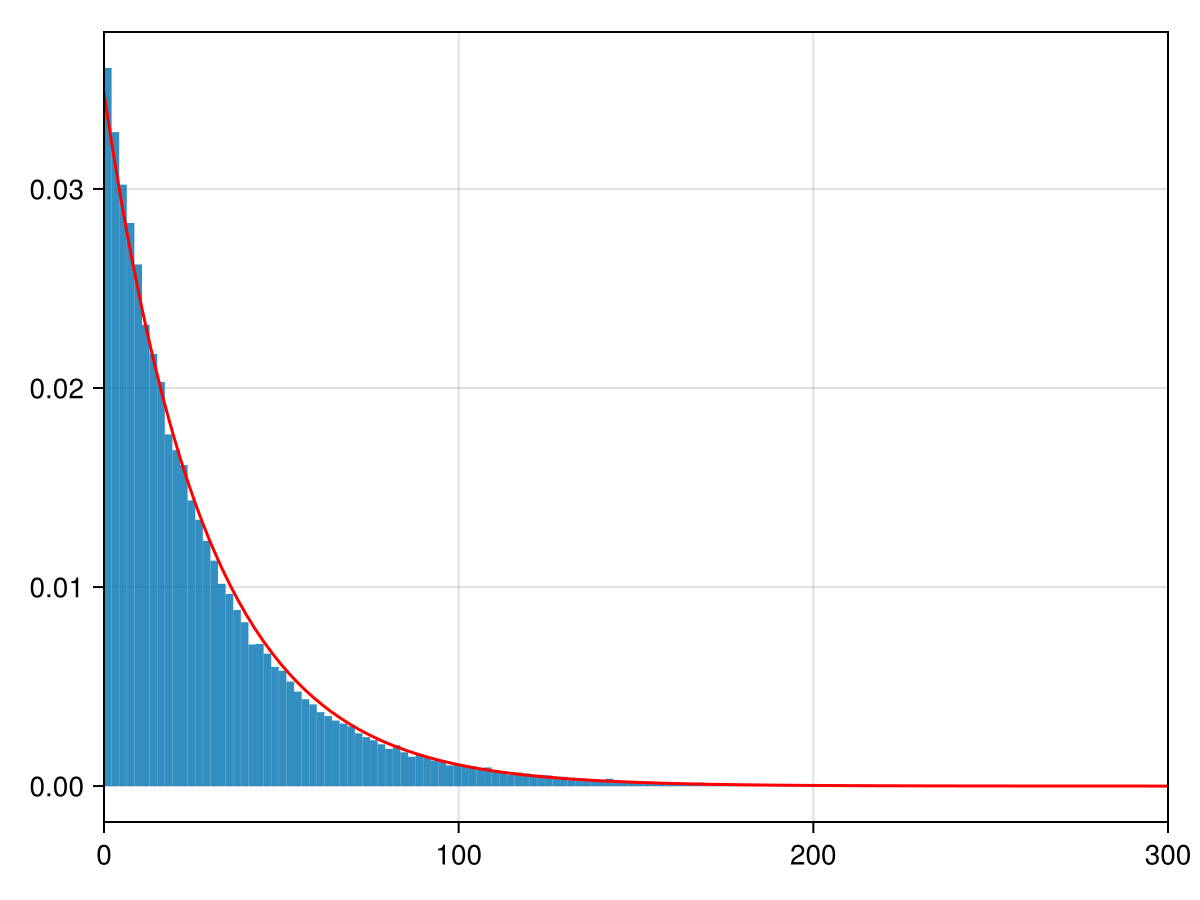

In [19]:
preds = bn * (rand(100000) .^ (-1/an) .- 1)
hist(preds, normalization = :pdf, bins = 300)
xlims!(low = 0, high = 300)
lines!(0..300, x -> pdf(Exponential(mean(posterior)), x), color = :red)
current_figure()

### Using the Turing package

Define the Bayesian model.

In [20]:
@model function bayes_exponential(y, n)
    # prior
    θ ~ InverseGamma(2, 30)

    # likelihood
    for i in 1:n
        y[i] ~ Exponential(θ)
    end
end

bayes_exponential (generic function with 2 methods)

Evaluate the model in the data.

In [21]:
m1 = bayes_exponential(data.time, 10)

DynamicPPL.Model{typeof(Main.var"##251".bayes_exponential), (:y, :n), (), (), Tuple{Vector{Float64}, Int64}, Tuple{}, DynamicPPL.DefaultContext}(Main.var"##251".bayes_exponential, (y = [20.78831313602355, 5.157479970876626, 49.445725075394265, 9.904663041485154, 0.07705144940575732, 80.41054648907986, 7.519265524213915, 99.26180880969429, 5.602735167658112, 7.496484258159109], n = 10), NamedTuple(), DynamicPPL.DefaultContext())

Sample from the posterior distribution using MCMC.

In [22]:
chain = Turing.sample(m1, NUTS(0.65), 10000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
└   ϵ = 0.05
Sampling   0%|▎                                         |  ETA: 0:01:57
Sampling   1%|▍                                         |  ETA: 0:00:58
Sampling   2%|▋                                         |  ETA: 0:00:39
Sampling   2%|▉                                         |  ETA: 0:00:29
Sampling   2%|█                                         |  ETA: 0:00:23
Sampling   3%|█▎                                        |  ETA: 0:00:19
Sampling   4%|█▌                                        |  ETA: 0:00:16
Sampling   4%|█▋                                        |  ETA: 0:00:14
Sampling   4%|█▉                                        |  ETA: 0:00:13
Sampling   5%|██▏                                       |  ETA: 0:00:11
Sampling   6%|██▎                                       |  ETA: 0:00:10
Sampling   6%|██▌                                       |  ETA: 0:00:09
Sampling   6%|██▊      

Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.01 seconds
Compute duration  = 1.01 seconds
parameters        = θ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           θ   28.7454    9.0551    0.1432   4217.2095   5858.0430    1.0006   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           θ   15.9284   22.4747   27.2311   33.2291   50.2946


Visualise traceplot and density of the posterior.

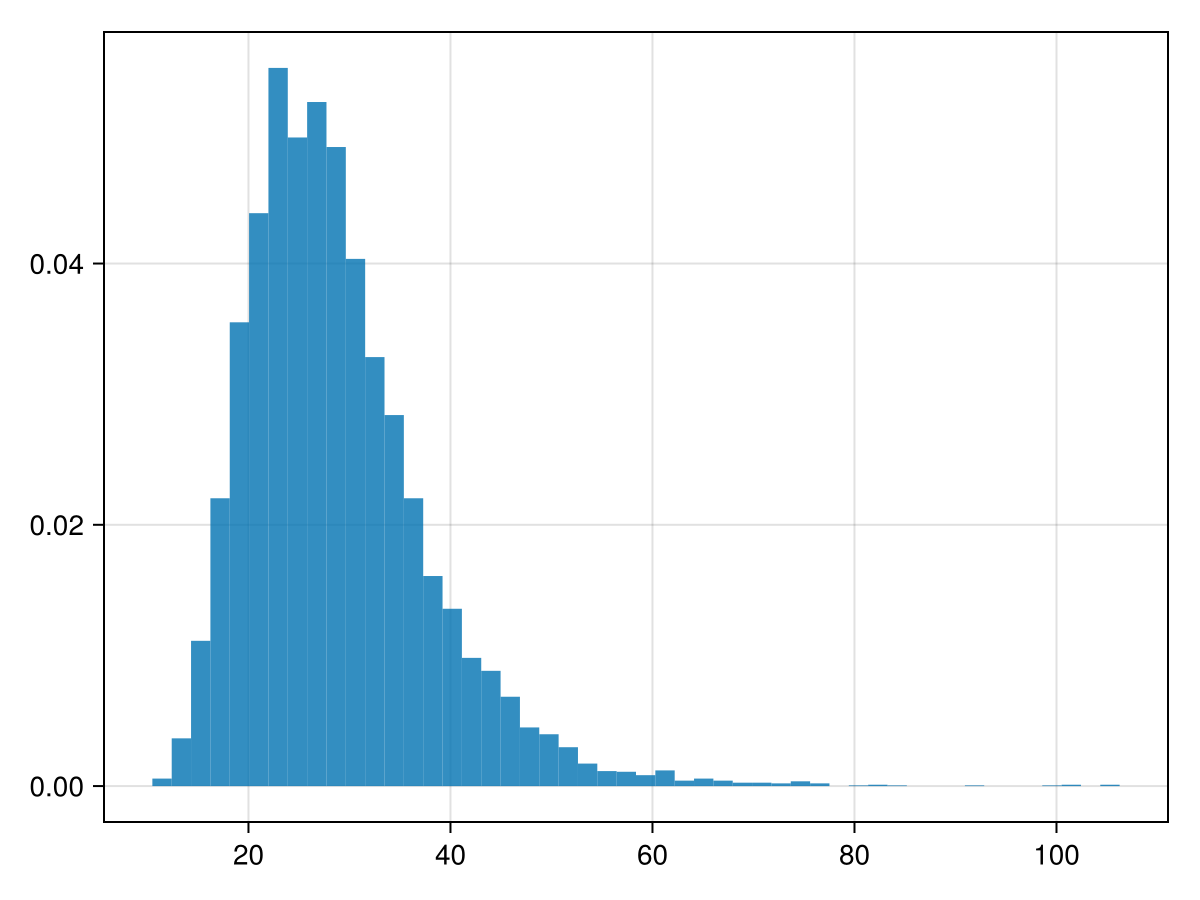

In [23]:
postsamples = vec(get(chain, :θ)[1])
hist(postsamples, bins = 50, normalization = :pdf)

Visualise prior and posterior densities.

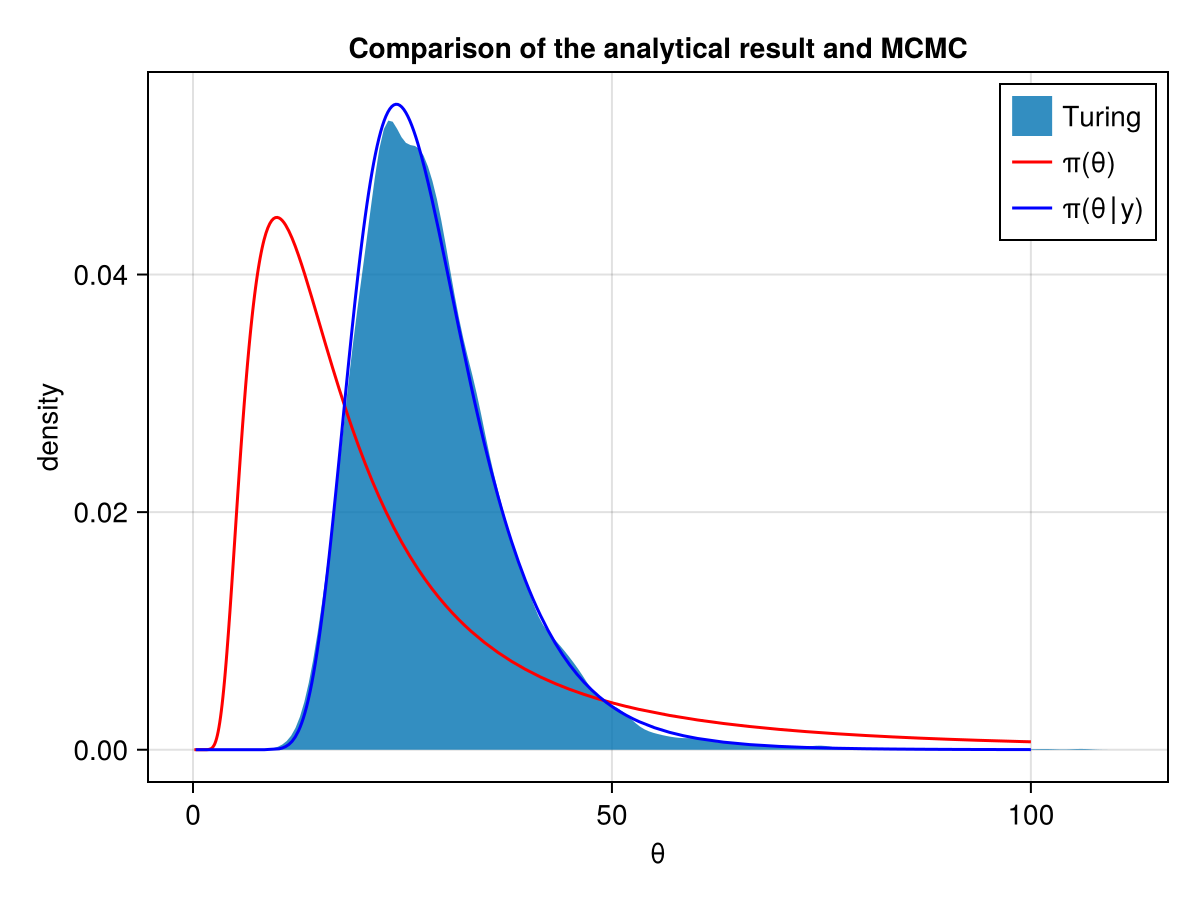

In [24]:
axis_args = (xlabel = "θ", ylabel = "density",
    title = "Comparison of the analytical result and MCMC")
density(postsamples, label = "Turing", axis = axis_args)
lines!(0..100, x -> pdf(prior, x), label = "π(θ)", color = :red)
lines!(0..100, x -> pdf(posterior, x), label = "π(θ∣y)", color = :blue)
axislegend()
current_figure()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*